In [3]:
from constants import EXPRESSION_PATH, CLINICAL_DATA_PATH


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

In [4]:
clinical_data = pd.read_csv(CLINICAL_DATA_PATH)
gene_expression = pd.read_csv(EXPRESSION_PATH)

In [5]:
gene_expression.groupby(['Diagnosis'])['Key'].count()

Diagnosis
AD     232
CTL    254
MCI    219
Name: Key, dtype: int64

In [6]:
gene_expression.groupby(['Diagnosis'])['Age'].mean()

Diagnosis
AD     72.697248
CTL    66.327189
MCI    73.736041
Name: Age, dtype: float64

In [13]:
def make_volcano_plot(df, group1_name, group2_name, confidence = 0.95):
    group_column = "Diagnosis"  

    meta_cols = ["Key", "Visit", "Month", "Site", "Diagnosis", "Sex", "Age", "APOE", "MMSE", "Gexp_batch"]
    gene_expression = df.drop(columns=meta_cols)  # оставляем только гены

    group1 = df[df[group_column] == group1_name].index
    group2 = df[df[group_column] == group2_name].index

    dea_results = pd.DataFrame(index=gene_expression.columns)
    p_values = []
    logFC = []

    for gene in gene_expression.columns:
        t_stat, p_val = ttest_ind(gene_expression.loc[group1, gene], gene_expression.loc[group2, gene], equal_var=False)
        p_values.append(p_val)
        
        mean_group1 = gene_expression.loc[group1, gene].mean()
        mean_group2 = gene_expression.loc[group2, gene].mean()
        logFC.append(np.log2(mean_group1 / mean_group2) if mean_group2 != 0 else np.nan)

    dea_results["logFC"] = logFC
    dea_results["p_value"] = p_values

    dea_results["adj_p_value"] = multipletests(dea_results["p_value"], method="fdr_bh")[1]

    dea_results["Significant"] = "No"
    dea_results.loc[(dea_results["adj_p_value"] < 1 - confidence) & (abs(dea_results["logFC"]) > 1), "Significant"] = "Yes"

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=dea_results["logFC"], 
        y=-np.log10(dea_results["p_value"]), 
        hue=dea_results["Significant"], 
        palette={"Yes": "red", "No": "gray"}, 
        alpha=0.7
    )
    plt.axhline(-np.log10(0.05), color="black", linestyle="--", linewidth=1)  # Линия порога значимости
    plt.xlabel(f"Log2 Fold Change (left - downregulation, right - upregulation in {group1_name})")
    plt.ylabel("-Log10 P-value")
    plt.title(f"Volcano Plot: {group1_name} vs {group2_name}")
    plt.legend(title="Significance")
    plt.show()

    return dea_results

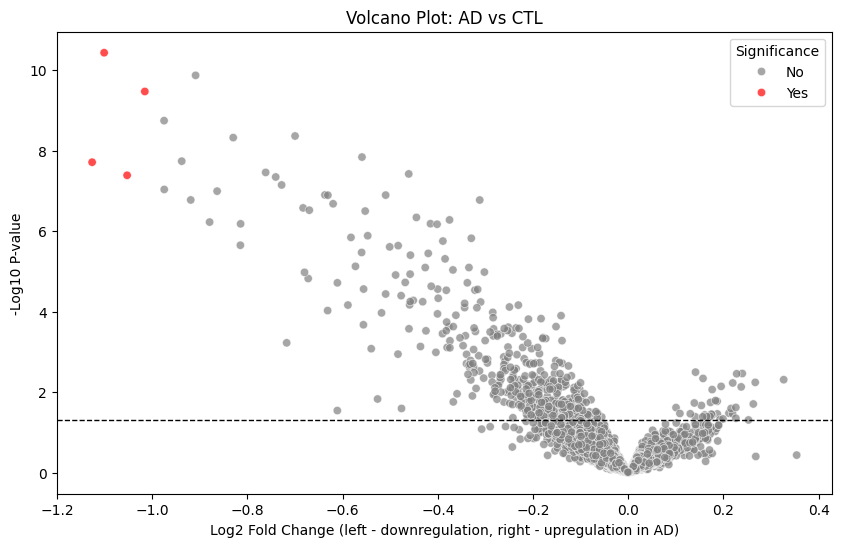

In [ ]:
res_1 = make_volcano_plot(gene_expression, "AD", "CTL", confidence=0.95)

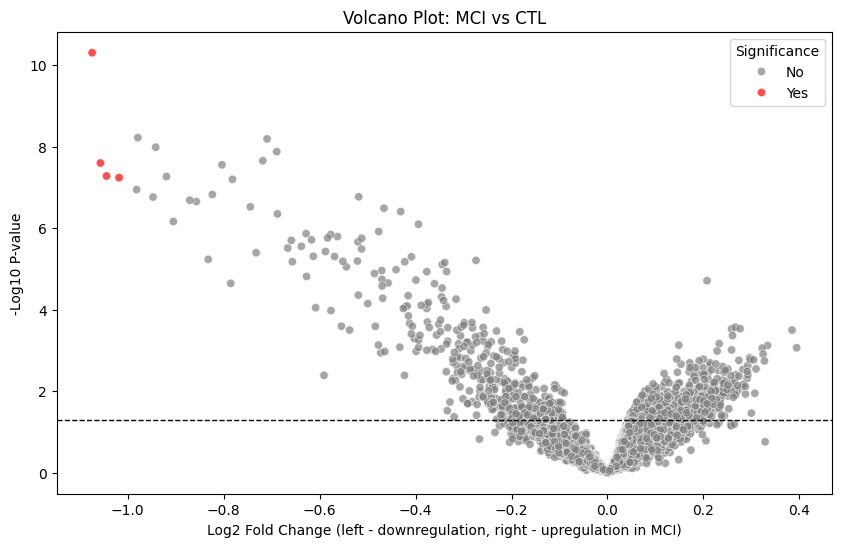

In [18]:
res_2 = make_volcano_plot(gene_expression, "MCI", "CTL", confidence=0.95)